## Анализ статистики по COVID

исходные данные взяты из kaggle: https://www.kaggle.com/ashudata/covid19dataset?select=COVID_Data_Basic.csv


In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
# загрузим данные
dfcovid = pd.read_csv('COVID_Data_Basic.csv')
dfcovid.head(2)

,Unnamed: 0,Country,Date,Confirmed,Death,Recovered,newConfirmed,newDeath,newRecovered
0,1,Afghanistan,2019-12-31,0,0,0,0,0,0
1,2,Afghanistan,2020-01-01,0,0,0,0,0,0


In [8]:
# загрузим справочник стран с населением и континентами
df_country = pd.read_excel('countries.xlsx', index_col = "Country")
df_country.head()

,geoId,continentExp,popData2019
Country,,,
Afghanistan,AF,Asia,38041757
Albania,AL,Europe,2862427
Algeria,DZ,Africa,43053054
Andorra,AD,Europe,76177
Angola,AO,Africa,31825299


In [10]:
#объединим данные
new_df = pd.merge(dfcovid, df_country, how='inner', left_on='Country', right_index=True)
new_df.head(2)

,Unnamed: 0,Country,Date,Confirmed,Death,Recovered,newConfirmed,newDeath,newRecovered,geoId,continentExp,popData2019
0,1,Afghanistan,2019-12-31,0,0,0,0,0,0,AF,Asia,38041757
1,2,Afghanistan,2020-01-01,0,0,0,0,0,0,AF,Asia,38041757


In [11]:
# выберем top12 стран Европы у которых выявлено наимбольшее количество заболевших 
# (так колонка Confirmed считает с накопительным итогом, то возьмем за последню дату в dataset) 
df1 = new_df.loc[(new_df['Date'] == '2020-06-18') & (new_df['continentExp']=='Europe')] 
df2 = df1.sort_values('Confirmed',ascending = False)
df3 = df2.head(12)
# и сформируем список TOP12 стран
top12 = list(df3['Country'])
top12

['Russia',
 'Spain',
 'Italy',
 'France',
 'Germany',
 'Belgium',
 'Belarus',
 'Sweden',
 'Netherlands',
 'Portugal',
 'Ukraine',
 'Switzerland']

In [13]:
# выберем из объединенного датасет  датасет только по 12 странам
df = new_df[new_df['Country'].isin(top12)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2008 entries, 966 to 26457
Data columns (total 12 columns):
Unnamed: 0      2008 non-null int64
Country         2008 non-null object
Date            2008 non-null object
Confirmed       2008 non-null int64
Death           2008 non-null int64
Recovered       2008 non-null int64
newConfirmed    2008 non-null int64
newDeath        2008 non-null int64
newRecovered    2008 non-null int64
geoId           2008 non-null object
continentExp    2008 non-null object
popData2019     2008 non-null object
dtypes: int64(7), object(5)
memory usage: 203.9+ KB


In [14]:
# поменяем тип даты с текста на datetime
df['Date'] = df['Date'].astype('datetime64[ns]')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2008 entries, 966 to 26457
Data columns (total 12 columns):
Unnamed: 0      2008 non-null int64
Country         2008 non-null object
Date            2008 non-null datetime64[ns]
Confirmed       2008 non-null int64
Death           2008 non-null int64
Recovered       2008 non-null int64
newConfirmed    2008 non-null int64
newDeath        2008 non-null int64
newRecovered    2008 non-null int64
geoId           2008 non-null object
continentExp    2008 non-null object
popData2019     2008 non-null object
dtypes: datetime64[ns](1), int64(7), object(4)
memory usage: 203.9+ KB


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


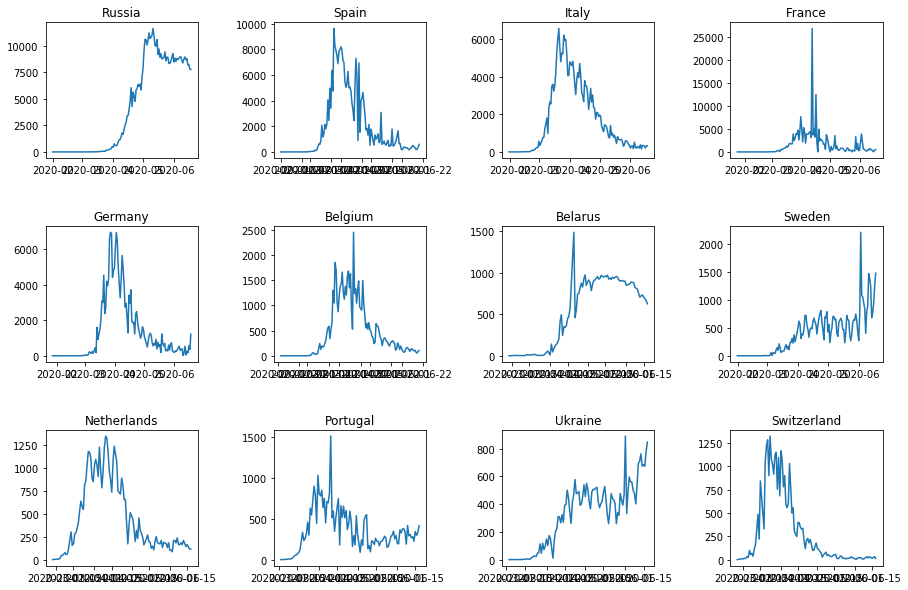

In [19]:
# построим графики по каждой из стран в топ12 - распределение по датам количество выявленных заболевших за день
fig, ax = plt.subplots(nrows=3, ncols=4)
fig.set_size_inches(15, 10)
fig.subplots_adjust(wspace=0.5, hspace = 0.5)

combi = [(0,0),(0,1),(0,2),(0,3), (1,0),(1,1),(1,2),(1,3),(2,0),(2,1),(2,2),(2,3)]

for i in range(12):
    y = df.loc[(df['Country']==top12[i]) & (df['newConfirmed'] > 0),('newConfirmed')]
    x = df.loc[(df['Country']==top12[i]) & (df['newConfirmed'] > 0),('Date')]
    ax[combi[i]].plot(x, y)
    ax[combi[i]].set_title(top12[i])

По графикам видно что в основном графики по странам западной Европы имеют схожую структуру, за исключением Швеции и у Португалии график также немного пошел снова в рост. Также есть схожесть у стран Восточной Европы, за исключением Украины у которой также наблюдается новый рост

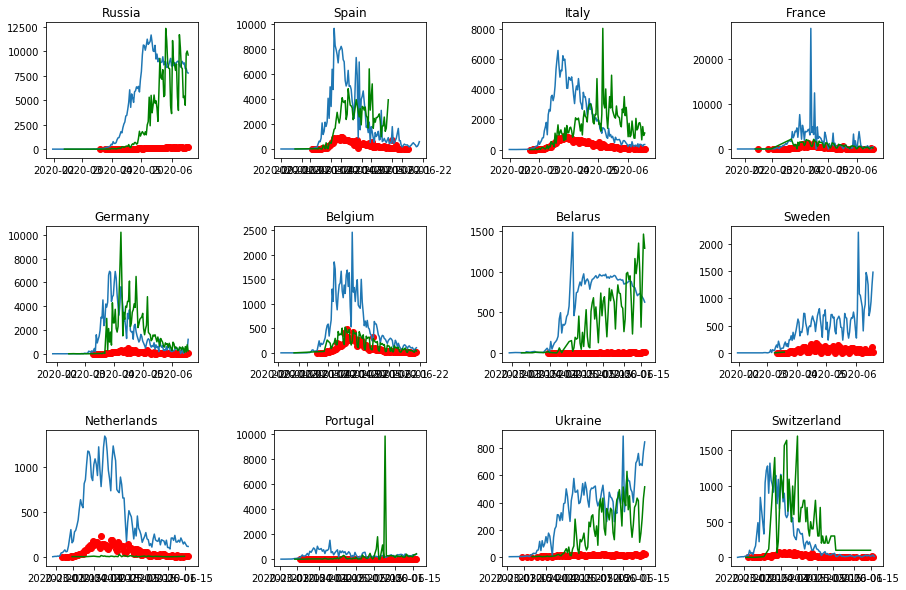

In [17]:
# выведем на графики дополнительно еще два наборых данных:
# синий график - выявленные за день, 
# красный - умершие за день, 
# зеленый - выздоровшие за день
fig, ax = plt.subplots(nrows=3, ncols=4)
fig.set_size_inches(15, 10)
fig.subplots_adjust(wspace=0.5, hspace = 0.5)

combi = [(0,0),(0,1),(0,2),(0,3), (1,0),(1,1),(1,2),(1,3),(2,0),(2,1),(2,2),(2,3)]

for i in range(12):
    y = df.loc[(df['Country']==top12[i]) & (df['newConfirmed'] > 0),('newConfirmed')]
    x = df.loc[(df['Country']==top12[i]) & (df['newConfirmed'] > 0),('Date')]
    y1 = df.loc[(df['Country']==top12[i]) & (df['newDeath'] > 0),('newDeath')]
    x1 = df.loc[(df['Country']==top12[i]) & (df['newDeath'] > 0),('Date')]
    y2 = df.loc[(df['Country']==top12[i]) & (df['newRecovered'] > 0),('newRecovered')]
    x2 = df.loc[(df['Country']==top12[i]) & (df['newRecovered'] > 0),('Date')]
    ax[combi[i]].plot(x, y)
    ax[combi[i]].scatter(x1, y1, color = 'red')
    ax[combi[i]].plot(x2, y2, color = 'green')
    ax[combi[i]].set_title(top12[i])

Графики по умершим в основном повторяют графики выявленных по форме а вот по выздоровшим - имеют большой разброс, что связано с предствалением данных по выздоровшим или например что выписку большых делают только несколько раз в неделю

Для дальнейшего анализа сгруппируем данные понедельно

In [20]:
df['week'] = df['Date'].dt.week
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,Country,Date,Confirmed,Death,Recovered,newConfirmed,newDeath,newRecovered,geoId,continentExp,popData2019,week
966,967,Belarus,2019-12-31,0,0,0,0,0,0,BY,Europe,9452409,1
967,968,Belarus,2020-01-01,0,0,0,0,0,0,BY,Europe,9452409,1
968,969,Belarus,2020-01-02,0,0,0,0,0,0,BY,Europe,9452409,1
969,970,Belarus,2020-01-03,0,0,0,0,0,0,BY,Europe,9452409,1
970,971,Belarus,2020-01-04,0,0,0,0,0,0,BY,Europe,9452409,1


In [21]:
df.describe()

,Unnamed: 0,Confirmed,Death,Recovered,newConfirmed,newDeath,newRecovered,week
count,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000
mean,32299.959163,47945.998506,4152.970618,21383.894422,874.269920,66.434761,503.999502,13.092629
std,54146.723615,84426.867929,8330.705520,46943.841914,1985.928405,166.387847,1345.539304,6.956508
min,967.000000,0.000000,0.000000,0.000000,-10034.000000,-1918.000000,-30.000000,1.000000
25%,7872.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
50%,12811.500000,5839.000000,98.000000,16.500000,167.000000,4.000000,0.000000,13.000000
75%,24348.250000,45935.500000,3709.250000,15416.250000,712.750000,49.250000,300.000000,19.000000
max,253210.000000,560321.000000,34514.000000,313409.000000,26849.000000,1438.000000,12331.000000,25.000000


In [22]:
# загрузим данные уже по свернутым понедельно данным и в колонки поместили страны, и обрезаны данные по первым неделям, 
# где только нули а также последняя неделя, так как она неполная

# первый датасет - по выявленным (newConformed)
df_c = pd.read_excel('newConfirmed.xlsx', index_col = "week")

# второй датасет - по умершим (newDeath)
df_d = pd.read_excel('newDeath.xlsx', index_col = "week")
df_c.head()

,Belarus,Belgium,France,Germany,Italy,Netherlands,Portugal,Russia,Spain,Sweden,Switzerland,Ukraine
week,,,,,,,,,,,,
4,0,0,3,0,0,0,0,0,0,0,0,0
5,0,0,3,10,2,0,0,2,1,1,0,0
6,0,1,5,4,1,0,0,0,1,0,0,0
7,0,0,1,2,0,0,0,0,0,0,0,0
8,0,0,0,0,152,0,0,0,0,0,0,0


Построим графики по свернутым данным понедельно:


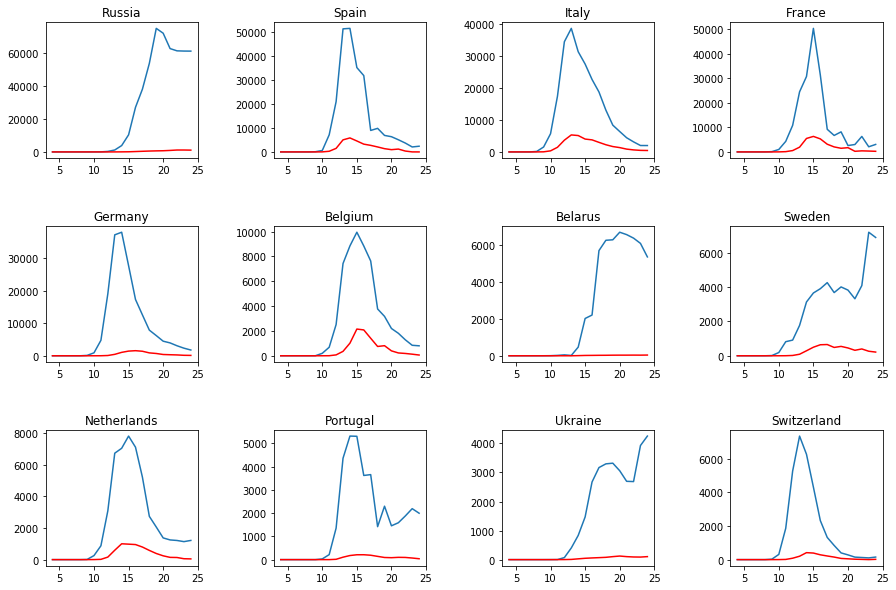

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=4)
fig.set_size_inches(15, 10)
fig.subplots_adjust(wspace=0.5, hspace = 0.5)

for i in range(12):
    ax[combi[i]].plot(df_c[top12[i]])
    ax[combi[i]].plot(df_d[top12[i]], color = 'red')
    ax[combi[i]].set_title(top12[i])

In [30]:
# Посчитаем корреляцию между выявленными и умершими в разрезе каждой из стран
print(f'Страна  \tКоэффициент корреляции\n -----------------------------')
for i in top12:
    print(f'{i}\t -\t {np.corrcoef(df_c[i],df_d[i])[0,1]}')

Страна  	Коэффициент корреляции
 -----------------------------
Russia	 -	 0.9221405183038694
Spain	 -	 0.9510740883407275
Italy	 -	 0.9658881971543091
France	 -	 0.9173991175097226
Germany	 -	 0.615886826104009
Belgium	 -	 0.8938549265863107
Belarus	 -	 0.9657743295404935
Sweden	 -	 0.7208532236609424
Netherlands	 -	 0.95110741073971
Portugal	 -	 0.8868952693787997
Ukraine	 -	 0.9489317510248704
Switzerland	 -	 0.735384722288624


Интересное наблюдение что коэффициент самый низкий наблюдается в  Германии и Швейцарии, при том что график умерших вроде как повторяет формой график выявленных (например больше чем по сравнению как в России)
В Швеции тоже ниже, но это объясняется тем что при росте выявленных в конце количесвто умерших пока снижается 

In [31]:
# посчитаем корреляцию между странами по выявленным и по умершим
CorC = df_c.corr() 
CorD = df_d.corr()
CorC 

,Belarus,Belgium,France,Germany,Italy,Netherlands,Portugal,Russia,Spain,Sweden,Switzerland,Ukraine
Belarus,1.000000,0.101217,-0.077270,-0.153253,-0.176203,0.042340,0.256560,0.977566,-0.183355,0.817870,-0.312774,0.937604
Belgium,0.101217,1.000000,0.908993,0.868752,0.801093,0.987822,0.932672,0.029150,0.859868,0.361577,0.723838,0.241370
France,-0.077270,0.908993,1.000000,0.850311,0.766685,0.927766,0.867482,-0.118819,0.863603,0.257684,0.746492,0.073560
Germany,-0.153253,0.868752,0.850311,1.000000,0.928214,0.913716,0.860783,-0.190747,0.984799,0.168703,0.958494,-0.034839
Italy,-0.176203,0.801093,0.766685,0.928214,1.000000,0.859622,0.735535,-0.219864,0.900829,0.101765,0.953378,-0.070478
Netherlands,0.042340,0.987822,0.927766,0.913716,0.859622,1.000000,0.937793,-0.018543,0.909099,0.355488,0.800101,0.201869
Portugal,0.256560,0.932672,0.867482,0.860783,0.735535,0.937793,1.000000,0.205703,0.841415,0.574013,0.709535,0.399903
Russia,0.977566,0.029150,-0.118819,-0.190747,-0.219864,-0.018543,0.205703,1.000000,-0.199326,0.812263,-0.335921,0.931917
Spain,-0.183355,0.859868,0.863603,0.984799,0.900829,0.909099,0.841415,-0.199326,1.000000,0.157077,0.938348,-0.043724
Sweden,0.817870,0.361577,0.257684,0.168703,0.101765,0.355488,0.574013,0.812263,0.157077,1.000000,0.014869,0.939556


In [32]:
CorD

,Belarus,Belgium,France,Germany,Italy,Netherlands,Portugal,Russia,Spain,Sweden,Switzerland,Ukraine
Belarus,1.000000,0.305017,0.195428,0.369845,0.016342,0.223333,0.506233,0.929954,0.040502,0.764085,0.081945,0.985061
Belgium,0.305017,1.000000,0.936747,0.972847,0.668819,0.917130,0.909753,-0.017891,0.727232,0.795423,0.860956,0.294631
France,0.195428,0.936747,1.000000,0.927363,0.795482,0.964295,0.898624,-0.105042,0.870384,0.675241,0.969451,0.199479
Germany,0.369845,0.972847,0.927363,1.000000,0.715922,0.956302,0.960011,0.051296,0.775499,0.851277,0.878112,0.366175
Italy,0.016342,0.668819,0.795482,0.715922,1.000000,0.861075,0.732185,-0.189983,0.947305,0.438435,0.881575,0.043297
Netherlands,0.223333,0.917130,0.964295,0.956302,0.861075,1.000000,0.938951,-0.072308,0.920233,0.721178,0.968895,0.230451
Portugal,0.506233,0.909753,0.898624,0.960011,0.732185,0.938951,1.000000,0.236038,0.805213,0.877205,0.861660,0.498533
Russia,0.929954,-0.017891,-0.105042,0.051296,-0.189983,-0.072308,0.236038,1.000000,-0.186897,0.505066,-0.190415,0.894543
Spain,0.040502,0.727232,0.870384,0.775499,0.947305,0.920233,0.805213,-0.186897,1.000000,0.476489,0.947421,0.064867
Sweden,0.764085,0.795423,0.675241,0.851277,0.438435,0.721178,0.877205,0.505066,0.476489,1.000000,0.564429,0.768918


Выделим только корреляции, модуль которых больше 0.4 и раскрасим

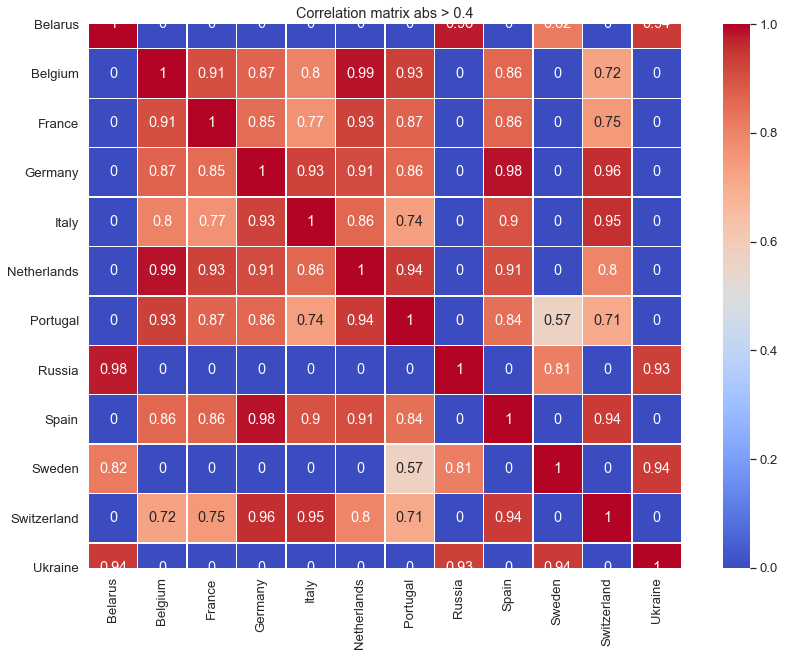

In [33]:
CorC[np.abs(CorC) < 0.4] = 0
plt.figure(figsize = (15,10))
sns.set(font_scale=1.2)
sns.heatmap(CorC, annot=True, linewidths=0.4, square=True, cmap='coolwarm')
plt.title('Correlation matrix abs > 0.4')
plt.show()

На графике видно хорошо что страны Западной Европы хорошо коррелируют по выявленным за исключением Швеции, которая лучше коррелирует с Россией, Беларусью и Украиной

Построим аналогичную талицу по умершим

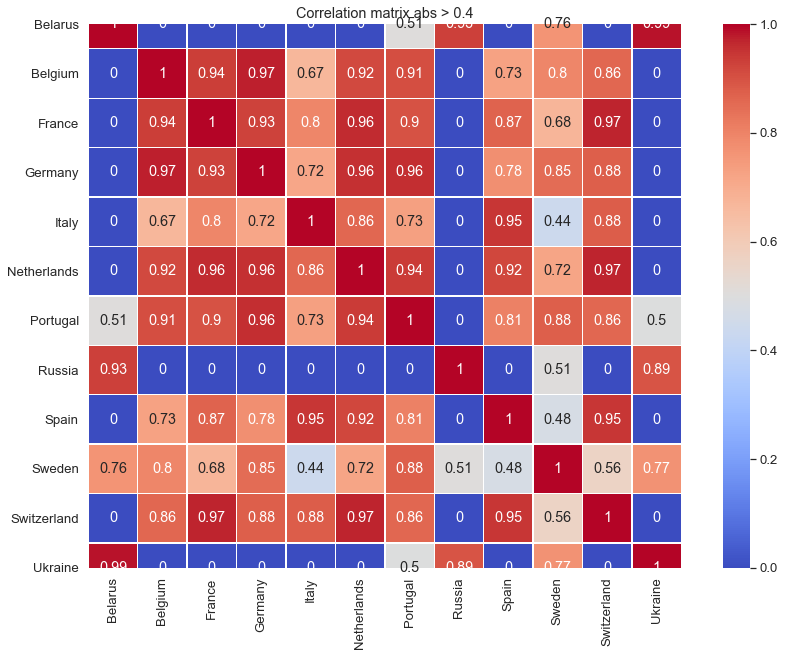

In [34]:
CorD[np.abs(CorD) < 0.4] = 0

plt.figure(figsize = (15,10))
sns.set(font_scale=1.2)
sns.heatmap(CorD, annot=True, linewidths=0.4, square=True, cmap='coolwarm')
plt.title('Correlation matrix abs > 0.4')
plt.show()

Здесь картина похожая на предыщий график, но здесь уже Швеция лучше коррелирует со странами Западной Европы чем со странами Восточной Европы

(array([73.,  5., 21., 37., 16.,  9.,  8.,  1.,  0.,  1.]),
 array([    0. ,  4453.7,  8907.4, 13361.1, 17814.8, 22268.5, 26722.2,
        31175.9, 35629.6, 40083.3, 44537. ]),
 <a list of 10 Patch objects>)

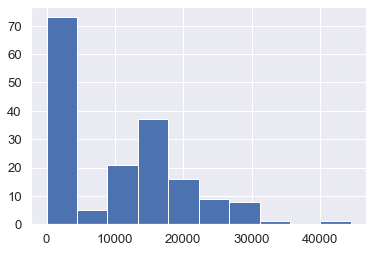

In [36]:
#Попробуем проверить на нормальность распределение по умершим на полном датасете по выявленным
d2 = df.groupby('Date')['newConfirmed'].sum()
plt.hist(d2)

Видим что в выборке много нулевых значений, попробуем убрать нули

(array([36.,  5., 21., 37., 16.,  9.,  8.,  1.,  0.,  1.]),
 array([1.00000e+00, 4.45460e+03, 8.90820e+03, 1.33618e+04, 1.78154e+04,
        2.22690e+04, 2.67226e+04, 3.11762e+04, 3.56298e+04, 4.00834e+04,
        4.45370e+04]),
 <a list of 10 Patch objects>)

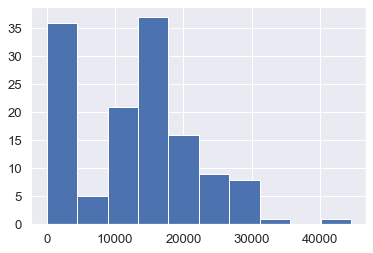

In [37]:
d3 = d2[d2 > 0]
plt.hist(d3)

Первый столбик уменьшился но все также присутствует и не дает сделать вывод что распределение нормальное

Попробуем по умершим:

(array([36., 25., 13.,  8.,  9., 13.,  4.,  6.,  3.,  2.]),
 array([1.0000e+00, 3.9680e+02, 7.9260e+02, 1.1884e+03, 1.5842e+03,
        1.9800e+03, 2.3758e+03, 2.7716e+03, 3.1674e+03, 3.5632e+03,
        3.9590e+03]),
 <a list of 10 Patch objects>)

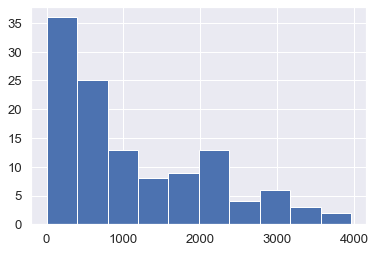

In [40]:
d4 = df.groupby('Date')['newDeath'].sum()
plt.hist(d4[d4 > 0])

Картина аналогичная
Если еще увеличить выборку и усреднить по всему миру:


(array([61.,  5.,  2., 13., 15., 24., 15., 11.,  5.,  2.]),
 array([1.0000e+00, 8.8740e+02, 1.7738e+03, 2.6602e+03, 3.5466e+03,
        4.4330e+03, 5.3194e+03, 6.2058e+03, 7.0922e+03, 7.9786e+03,
        8.8650e+03]),
 <a list of 10 Patch objects>)

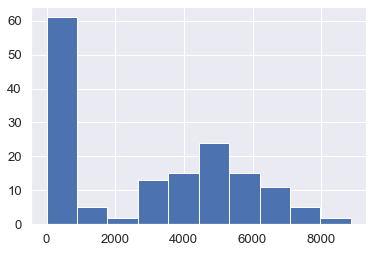

In [41]:
d5 = dfcovid.groupby('Date')['newDeath'].sum()
plt.hist(d5[d5 > 0])

Картина получается аналогичная, хотя можно подметить что имеется некое подобие нормального распредления для определенного количества умерших при превышении опредленного количества

(array([ 2.,  6., 14., 12., 21., 13.,  9.,  6.,  2.,  2.]),
 array([1918. , 2612.7, 3307.4, 4002.1, 4696.8, 5391.5, 6086.2, 6780.9,
        7475.6, 8170.3, 8865. ]),
 <a list of 10 Patch objects>)

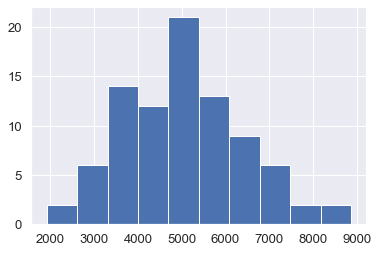

In [42]:
plt.hist(d5[d5 > 1773])

-----

### Дисперсионный анализ

Сделаем дисперсионный анализ по умершим относительно стран из ТОП12 из исходных данных

За Нулевую гипотеза $H_0$ примем, что средние по умершим относительно стран равны:
$$H_0: \:\: \overline{Y_1} = \dots = \overline{Y_k}$$


In [44]:
#вычислим средние по каждой из стран и общую средню ()
d_means = dict(df.groupby('Country')['newDeath'].mean())
d_mean = df['newDeath'].mean()
d_means, d_mean

({'Belarus': 1.935672514619883,
  'Belgium': 56.62573099415204,
  'France': 173.1345029239766,
  'Germany': 51.900584795321635,
  'Italy': 201.83625730994152,
  'Netherlands': 35.654970760233915,
  'Portugal': 10.228187919463087,
  'Russia': 44.73684210526316,
  'Spain': 158.69005847953215,
  'Sweden': 29.549707602339183,
  'Switzerland': 11.43859649122807,
  'Ukraine': 6.550335570469799},
 66.4347609561753)

In [46]:
# вычислим количество элементов в выборке по каждой из стран
d_n = dict(df.groupby('Country')['newDeath'].count())
d_n

{'Belarus': 171,
 'Belgium': 171,
 'France': 171,
 'Germany': 171,
 'Italy': 171,
 'Netherlands': 171,
 'Portugal': 149,
 'Russia': 171,
 'Spain': 171,
 'Sweden': 171,
 'Switzerland': 171,
 'Ukraine': 149}

In [59]:
# Определим функцию по вычислению F - статистики на основе dataframe (df), списка стран (сс) и по значениям (param)  
def F_stat(df, cc, param):
    means = dict(df.groupby('Country')[param].mean())
    mean_df = df[param].mean()
    nn = dict(df.groupby('Country')[param].count())
    SS_b = 0
    SS_w = 0
    for c in cc:
        SS_b += nn[c]*(means[c]-mean_df)**2
        SS_w += (np.array((df.loc[df['Country'] == c,(param)] - means[c]))**2).sum()
    k = len(cc)
    # n = sum(nn.values())
    n = 0
    for c in cc:
        n += nn[c]
    k1 = k - 1
    k2 = n - k
    sigma2_b = SS_b / k1
    sigma2_w = SS_w / k2
    return ((sigma2_b / sigma2_w), k1,k2)


In [60]:
# Вычислим F - статистику по умершим за день по странам из TOP12
f, k1, k2 = F_stat(df,top12,'newDeath')
f, k1, k2

(36.469766303952845, 11, 1996)

In [61]:
# Распределение Фишера для полученных k1 и k2 будет:
alpha = 0.05
t = stats.f.ppf(1 - alpha, k1, k2)
t

1.7934357697622718

Наше значение 36.4698 попадает в критическую область, что отвергает нулевую гипотезу, следовательно фактор страны вносит существенную разницу по выборке умерших за день

In [62]:
# Вычислим F - статистику по заболевшим за день по странам из TOP12
f, k1, k2 = F_stat(df,top12,'newConfirmed')
f, k1, k2

(42.94184567627062, 11, 1996)

k1 и k2 здесь и сравнивая полученную статистику мы видим что она еще дальше уходит в критическую область, тогда отвергается и нулевая гипотеза и по выявленным за день


Изучая графики по выявленным мы видим что график заболевающих в Германии, Испании и Италии очень близкие, попробуем посчитать статистику по ним

In [63]:
top3 = ['Germany', 'Spain','Italy']
f, k1, k2 = F_stat(df,top3,'newConfirmed')
f, k1, k2

(13.20658606602633, 2, 510)

In [64]:
# Распределение Фишера для полученных k1 и k2 будет:
alpha = 0.05
t = stats.f.ppf(1 - alpha, k1, k2)
t

3.0133982716339918

Все равно попадает в критическую область, несмотря на близость графиков по выборкам